# Quarterly QA on Siemens Scanners

On most systems this is performed on the Siemens *long bottle* phantom in the most used head coil. On VE and XA systems this will be either the standard 20 element Head and Neck coil or the 32 channel head coil. The phantom is the same one that is used for the Siemens coil QA and so it can be easily and reproducibly positioned using the dedicated Siemens foam pad.

The bandwidth used should be approximately scaled with the field strength so 130Hz at 1.5T and 260Hz at 3.0T.

The quarterly QA consists of the following scans:
 - SE, 2 acquisitions (dynamic), with/without PSN, multiple elements, RMS coil combination, no distortion correction
   - SNR, uniformity, ghosting, and phantom  geometry
 - SE, 2 acquisitions (dynamic), without PSN only, multiple elements, RMS coil combination, TX switched off by setting reference voltages to zero in the UI or in the Adjustments panel
   - Noise levels in elements and crosstalk.

and optionally:
 - EPI, 60+ acquisitions: ghosting and long term stability, eddy currents and shim (distortion)

The acquisitions should have the following labels in the protocol to make them easier to identify:
 - `QQA_SE_SIGNAL`
 - `QQA_SE_NOISE`
 - `QQA_EPI_STABILITY`

In [1]:
# Patient details file yaml/json
import yaml

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd

from datetime import datetime, timedelta

def df_repr_latex(self):
    return '\n'.join([
        r'\begin{center}',
        r'\vspace{5mm}',
        r'{\small{%s}}' % self.to_latex(),
        r'\vspace{5mm}'
        r'\end{center}',
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()
pd.set_option('display.precision', 2)

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from mriqa.phantoms import SIEMENSLONGBOTTLE, SIEMENSSHORTBOTTLE
from mriqa.dcmio import (
    fetch_series, coil_elements, qa_date, scanner_operator,
    larmor_frequency, transmitter_calibration, tales_reference_power, gradient_sensitivities,
    software_versions
)
from mriqa.tools import show_montage, watermark

from mriqa.reports import (
    ghosting_report, uniformity_report, noise_correlation_report,
    circularity_report, snr_report_multi
)

# Watermark
wm = watermark()
display(pd.DataFrame(
    {'Watermark': list(wm.values())},
    index=wm.keys()
))


def show_test_result(passed):
    if passed:
        return HTMLLatex(
            '<b>Test Result - <span style="color:green">ACCEPTABLE</span></b>',
             r'\textbf{Test Result -- \color{green}ACCEPTABLE}'
        )
    else:
        return HTMLLatex(
            '<b>Test Result - <span style="color:red">FAILED</span></b>',
             r'\textbf{Test Result -- \color{red}FAILED}'
        )

Watermark
CalculationTime  2022-04-19T10:48:14+01:00
User                        birchhub/rtrhd
PythonVersion                CPython 3.9.9
Platform          Linux 4.15.0-159-generic
mriqa                               0.2.11
dcmextras                            0.2.6
pydicom                              2.2.2
scipy                                1.7.3
numpy                               1.22.0
skimage                             0.19.1
matplotlib                           3.5.1

The phantom used can specified here.

In [2]:
phantom = SIEMENSLONGBOTTLE

The details needed to fetch the QA scans from the DICOM server are specified in a [yaml](https://en.wikipedia.org/wiki/YAML) text file `study.yml` in the same directory as this notebook.

### Series Details
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [3]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)
patid = study_info['PatID']
studyid = study_info['StudyID']
series = study_info['Series']

dobj = fetch_series(patid, studyid, sernos=series['Signal'])[0]
scanner, date_of_scan, operator = dobj.StationName, qa_date(dobj), scanner_operator(dobj, default='BIRCH')
display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, operator, patid, studyid] + list(series.values())}, 
        index=['Scanner', 'Date', 'Operator', 'Patient', 'Study'] + list(series.keys())
    )
)

Details
Scanner                   AWP183105
Date                       20211210
Operator                      BIRCH
Patient          QQA20211210COSSOLA
Study              a38bda7a-b8fe-46
Signal                         [10]
Signal_Combined                [16]
Noise                           [8]
Noise_Combined                  [9]
Geometry                       [13]
TuneupParams                    [5]

After running this notebook a summary of the results and any recommendations should be entered below.

# Summary

The following tests were performed as part of the quarterly checks:

 - Head Coil SNR -- PASSED
 - Distortion and Scaling -- PASSED
 - Ghosting -- PASSED
 - Head Coil Uniformity (Axial) -- PASSED

### Recommended Actions

No actions necessary.

In [4]:
qqadate = (datetime.strptime(date_of_scan, '%Y%m%d') + timedelta(days=92)).strftime('%B %Y')

text = f'''
This machine is next due for quarterly QA tests in {qqadate}.
'''

HTMLLatex(text, text)

----

In [5]:
text = f'''
BIRCH
Medical Physics & Bioengineering, UHBW
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

HTMLLatex(
    f'<pre>{text}</pre>',
    '\n'.join([
        r'\begin{verbatim}',
        text,
        r'\end{verbatim}'
    ])
)

In [6]:
NewPage

For each of the tests below there is a code cell to edit to say if the results were satisfactory and a markdown cell with any commentary on the results. Where a fault is evident in the SNR related tests the Siemens standard coil QA should be run on the head coil to see if the SNR of any elements falls below Siemens specified minima.

# Detailed Results
The detailed results for each of the tests run are presented below.

----

## Head Coil SNR

We have separate images corresponding to the individual elements of the receive-only headcoil. We expect the images to be extremely non-uniform and also that some will be much brighter than others depending on the sensitivity of the element at the position of the (single) acquired slice. There should however be some intensity in all the images and the absence of any signal at all in an image is an indication of a faulty element.

### Individual coil element images
The images from each element of the array coil before combination are shown below.

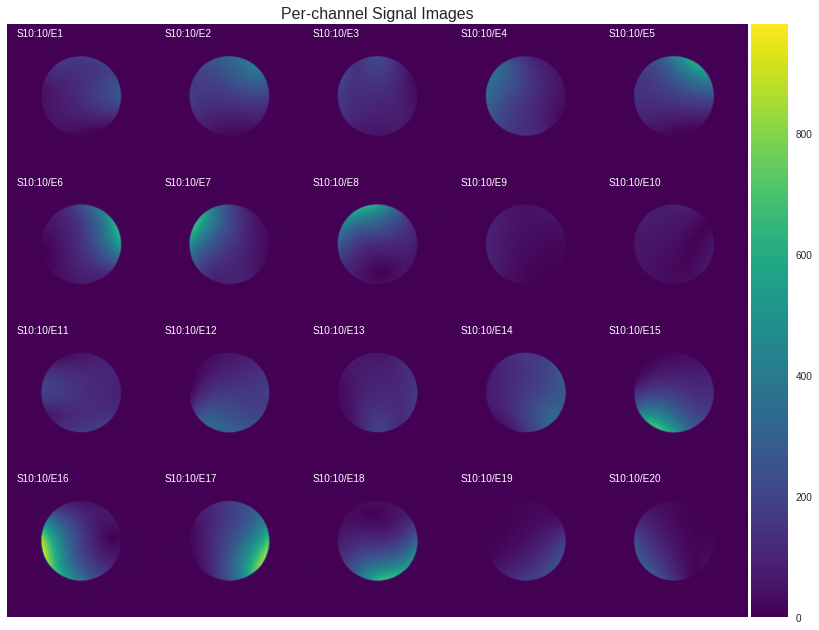

In [7]:
# Assume just one element
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Signal']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

show_montage(dobjsa, dobjsb, op='mean', cmap='viridis', title='Per-channel Signal Images');

In [8]:
show_test_result(True)

All coils show some signal intensity. They are expected to be non-uniform with variation in signal intensity depending on each coil's sensitivity at the slice position.

In [9]:
NewPage

One way of investigating the noise characteristics of the coil elements is to acquire images with no MR signal present at all. For Siemens scanners we are able to do this by setting the transmitter voltage to zero, either directly in the `System` tab of the UI or (for older VB systems) using the manual adjustments panel. Note that this setting is not generally persistent in the protocol so has to be done each time the protocol is run.

The noise will be a combination of thermal noise from the phantom and noise from the receiver electronics. As the coil elements are sensitive to similar volumes of the phantom, we expect the overall levels of noise in each of the uncombined images to be roughly similar. An increased noise level in one of the images or a lack of noise both indicate a faulty element. In the absence of any non-linear filtering of the images we also expect the noise within each image to be spatially uniform.

### Coil Element Noise Images (Zero TX Voltage)
Individual noise images for each of the coil elements were acquired by setting the transmitter voltage to zero. These are shown below.

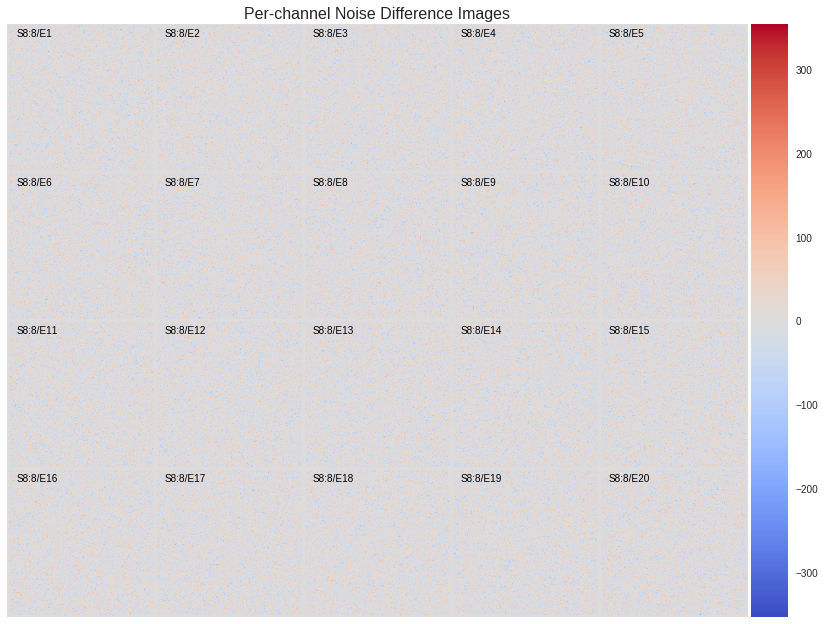

In [10]:
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Noise']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]
show_montage(dobjsa, dobjsb, op='diff', cmap='coolwarm', title='Per-channel Noise Difference Images');

In [11]:
show_test_result(True)

These show no significant intensity variations or bias and are similar for each element.

In [12]:
NewPage

We can also look at the degree of correlation between the noise in the different coil element channels along with the variation of noise power between the channels in the form of a covariance matrix. The elements should be well decoupled from each other so we expect little cross-correlation in the noise and nearly all the power in the matrix should be along the diagonal. Any significant off-diagonal entries indicate an unwanted coupling between the coil elements and a possible problem with the coil. Similarly, any strong variation along the diagonal, which corrsponds to differing noise levels in the channels, is a cause for concern. 

Ideally, we would calculate this covariance matrix using the complex raw data. However, as the magnitude image data is much more readily available we approximate this by using the *difference* of two images sets acquired as a *dynamic*. We assume that the covariance matrix thus obtained is still representative of the coil correlations.

The left hand plot shows values along the diagonal as a bar graph. The right hand plot is the covariance matrix as a heat map.  

### Noise Image Channel Covariance (Crosstalk)
The deviation in noise power between coil elements is shown on the left and a map of correlations between elements is shown on the right.

HeadNeck_20_TCS
MinCorrelation              -36.492
MaxCorrelation             3732.111
DiagonalVariance              0.009
MaximumOffDiagonal            0.232

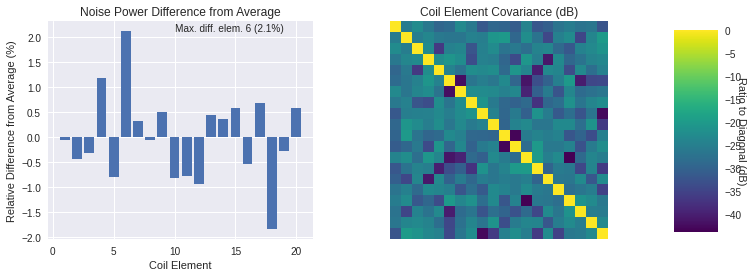

In [13]:
df = noise_correlation_report(dobjsa, dobjsb).T
with pd.option_context('display.precision', 3):
   display(df)

In [14]:
show_test_result(True)

The noise power is broadly similar across the channels and there is no significant covariance/crosstalk between them. Note that the images in this case have had 2D distortion correction applied which may have slightly altered the noise statistics.

In [15]:
NewPage

There are various ways to estimate the overall SNR of the coil. Here, we use the subtraction method but still use a backgound region for the noise component. This assumes the noise is stationary, which precludes the use of any non-linear filters such as for intensity normalisation or geometric distortion correction. On the other hand, it is insenstive to scan to scan variations in the phantomn forground.

As we have the individual coil element images available, we combine them here as root-sum-of-squares and check that the background noise distributions are as expected, both for a single image and for a subtracted pair. The former is expected to be a central-$\chi$ distribution and the latter at least symmetric by consruction.

The quoted SNR figures are for the central 50% and 75% (by radius) of the phantom. The noise level is derived from a background region in the subtraction image.

### Signal to Noise Ratio
The histograms below show the noise in the indicated background regions for a single image (left) and the difference between two identical acquisitions (right). The SNR values in the central 50% and 75% of the phantom are shown in the table.

HeadNeck_20_TCS
0.50           276.96
0.75           304.16

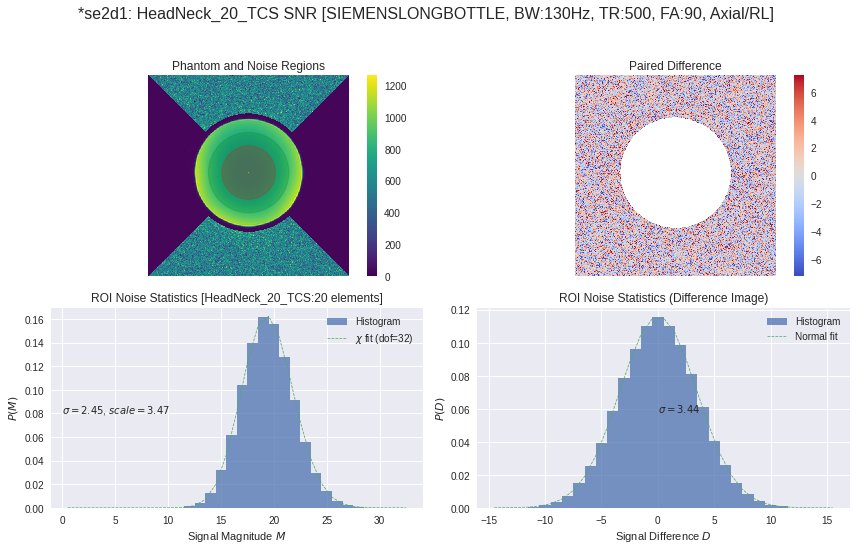

In [16]:
# SNR (uncombined channels)
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Signal']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

snr_report_multi(dobjsa, dobjsb, phantom=phantom)

In [17]:
show_test_result(True)

The combined element images have the expected noise characteristics. The signal-to-noise ratios calculated in ROIs encompassing the central 50% and 75% of the phantom are consistent with previous values for this scanner. The low level Nyquist ghost seen in the acquiaistion at the previous visit is no longer apparent.

----

In [18]:
NewPage

There is limited scope for assessing the geometric distortion using just the uniform cylindrical phantom. However, we can measure the circularity of the phantom cross section by fitting the edge in the image to a sub-pixel precision and determining the distance between opposite points on the edge as a function of angle. If we fit a sinusoid function to the diameters function we can use that as en estimate of the non-circularity of the phantom.

The analysis should be done on the *Prescan Normalise* intensity corrected images to minimise errors in the edge determination arising from intensity variations. The results will depend on whether distortion correction has also been applied.

The left hand plot shows the edge positions as a function of angle and the right hand plot shows the phantom diameters along with a sinusoidal fit indicating eccentricity.

Owing to the relatively poorly defined geometry of the Siemens bottle phantoms only gross deviations of scale or large eccentricities will be clear indicative of system gradient issues. A more careful evaluation of distortion and scale is performed in the annual assessment.  

## Scale and Distortion (Phantom Circularity)
The average diameter and circularity of an axial slice of the cylindrical bottle phantom are shown below.

SIEMENSLONGBOTTLE
Nominal                     133.00
Diameter                    133.18
Deviation                     0.61
FittedDeviation               0.27

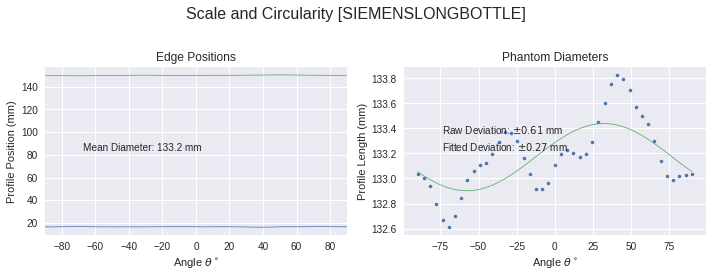

In [19]:
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Geometry']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber))
)
circularity_report(dobjs[0], phantom=phantom).T

In [20]:
show_test_result(True)

The mean diameter is within 1% of the expected value and the deviation from circular is acceptable.

----

In [21]:
NewPage

In the annual tests the image ghosting is assessed on a small *GE* sphere with a variety of sequences using the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf). We use the same analysis here but restrict ourselves to a spin echo aquuisition of the Siemens bottle.

The use of intensity normalisation or distortion will have a small effect on the results so, by preference, the combined but uncorrected images are used

The test compares the intensity in predefined *ghost* and *background* areas of the image, the former along the in-plane phase encoding direction where ghosts might be expected. The actual values obtained for the ghosting ratio will vary somewhat according to exactly where the ghosting regions of interest are defined. In particular, any ringing like artefacts close to the phantom will only be detected if the region of interest is equally close to the phantom edge. Nyquist ghosting on the other hand is best detected with an ROI that comprises the phantom shifted by N/2 in the *phase encoding* direction.

In addition, as the test compares the signal in background regions of interest along the phase encoding and the readout direction it is only sensitive to these separately (generally in the phase encoding direction). Anything that is manifest on both axes will cancel out in the subtraction.

The difference between the two regions is presented as a fraction of the average foregournd signal in the phantom.

## Ghosting
Image ghosting is assessed on an axial slice imaged with a standard spin echo. The ghosting ratio is the proportion of signal in the ghosts as a fraction of the signal in the phantom. 

Series                   16
Protocol     QQA_SNR_SIGNAL
Orientation           Axial
Sequence             *se2d1
GhostRatio             0.07

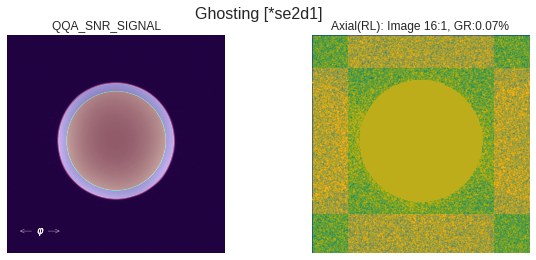

In [22]:
# BOTTLE: Ghosting
dobjs = fetch_series(patid, studyid, sernos=series['Signal_Combined'])
df = ghosting_report([dobjs[0]], phantom=phantom)
df[['Protocol', 'Orientation', 'Sequence', 'GhostRatio']].T

In [23]:
show_test_result(True)

The level of ghosting is acceptable.

----

In [24]:
NewPage

The image uniformity is evaluated by taking profiles in the vertical and horizontal directions through the centre of the phantom. For a full assessment all three axes would be measured in an oil filled sphere. In this case though we consider only the axial plane. In addition, although the test is intented as a measure of receive coil non-uniformities, the Siemens bottle is filled with an aqueous solution. This means that at higher fields, a contribution may be expected for non-uniformity in the body coil transmit field.

In any case, the images are root-mean-square combinations of a large number of local coil elements, which inevitably means there will be considerable non-uniformity. Typically the images are brighter away from the centre towrds the coil elements. Results here are for both the *raw* non-uniformity and for images corrected with the *prescan normalize* option. This may be taken as an assessment of how well the intensity normalisation compensates for the large intrinsic non-uniformity. 

## Uniformity
The axial uniformity is tested on a uniform cylinder both before and after *prescan normalize* intensity correction is applied.

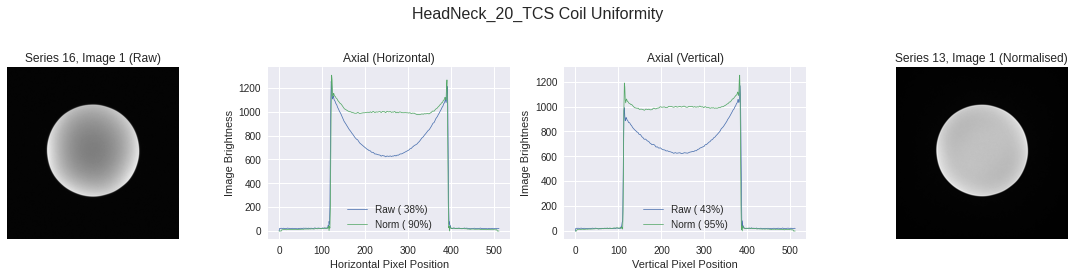

In [25]:
raw_dobjs = fetch_series(patid, studyid, sernos=series['Signal_Combined'])
psn_dobjs = fetch_series(patid, studyid, sernos=series['Geometry'])
df = uniformity_report(raw_dobjs=raw_dobjs[:1], psn_dobjs=psn_dobjs[:1], phantom=phantom)

In [26]:
df_raw = df[['XUniformityRaw','YUniformityRaw','NEMAUniformityRaw']].rename(
    columns={
        'XUniformityRaw':'X Uniformity',
        'YUniformityRaw':'Y Uniformity',
        'NEMAUniformityRaw':'NEMA Uniformity'},
    index={'Axial':'Raw'}
)

df_corrected = df[['XUniformityNorm', 'YUniformityNorm', 'NEMAUniformityNorm']].rename(
    columns={
        'XUniformityNorm':'X Uniformity',
        'YUniformityNorm':'Y Uniformity',
        'NEMAUniformityNorm':'NEMA Uniformity'},
    index={'Axial':'Corrected'}
)

pd.concat([df_raw, df_corrected])

X Uniformity  Y Uniformity  NEMA Uniformity
Orientation                                             
Raw                 37.91         42.75            89.24
Corrected           89.74         95.24            98.28

In [27]:
show_test_result(True)

As expected for a multi-element coil the uncorrected image is significantly non-uniform. However, the Siemens prescan-normalize provides adequate compensation.

----

It is helpful to track some of the system calibration factors to the extent they are available from the DICOM image headers. For consistency, we use the combined signal image for this purpose.

## Frequency Reference and Transmitter Voltage

These are the reference values reported in the DICOM headers.

In [28]:
# Siemens Long Bottle: localizer
dobj = fetch_series(patid, studyid, sernos=series['TuneupParams'])[0]

df = pd.DataFrame({
    'ImagingFrequency': [larmor_frequency(dobj)],
    'TransmitterCalibration': [transmitter_calibration(dobj)],
    'TalesReferencePower': [tales_reference_power(dobj)],
    'GradientSensitivityX': [
        float(gradient_sensitivities(dobj)[0]) * 1e6,
    ],
    'GradientSensitivityY': [
        float(gradient_sensitivities(dobj)[1]) * 1e6,
    ],
    'GradientSensitivityZ': [
        float(gradient_sensitivities(dobj)[2]) * 1e6,
    ]
}, index=['Value']).T
df

Value
ImagingFrequency          63.68
TransmitterCalibration   296.95
TalesReferencePower     1279.24
GradientSensitivityX      90.92
GradientSensitivityY      92.34
GradientSensitivityZ      93.56

----